<a href="https://colab.research.google.com/github/Anou26/Mini-Project/blob/main/ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels.api as sm

In [ ]:
url = "https://raw.githubusercontent.com/Anou26/Major-Project/main/%5ENSEI%20(5).csv"

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv(url,sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-16,12131.349609,12134.650391,12046.299805,12053.950195,12053.950195,437700.0
2019-12-17,12082.450195,12182.750000,12070.349609,12165.000000,12165.000000,499600.0
2019-12-18,12197.000000,12237.700195,12163.450195,12221.650391,12221.650391,518900.0
2019-12-19,12223.400391,12268.349609,12191.150391,12259.700195,12259.700195,623100.0
2019-12-20,12266.450195,12293.900391,12252.750000,12271.799805,12271.799805,810700.0
...,...,...,...,...,...,...
2022-01-19,18129.199219,18129.199219,17884.900391,17938.400391,17938.400391,276700.0
2022-01-20,17921.000000,17943.699219,17648.449219,17757.000000,17757.000000,258100.0
2022-01-21,17613.699219,17707.599609,17485.849609,17617.150391,17617.150391,277600.0


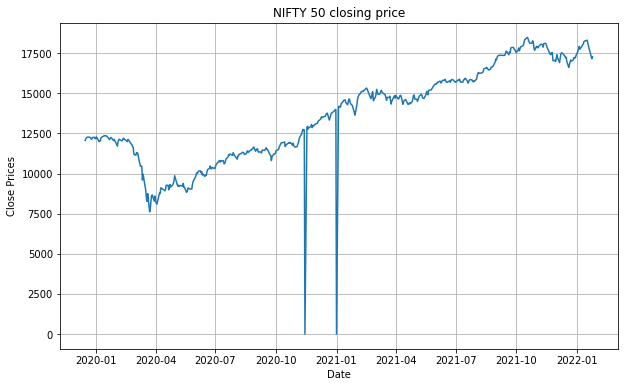

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('NIFTY 50 closing price')
plt.show()

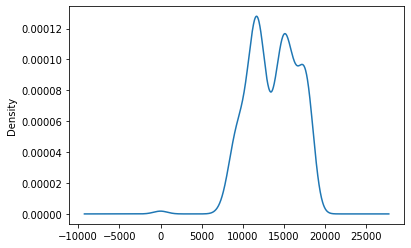

In [ ]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

In [ ]:
stock_data = stock_data.drop(stock_data.index[[232,264]]) #these rows had Null values throughout
stock_data = stock_data.dropna() #removing the NA values

In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525 entries, 2019-12-16 to 2022-01-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       525 non-null    float64
 1   High       525 non-null    float64
 2   Low        525 non-null    float64
 3   Close      525 non-null    float64
 4   Adj Close  525 non-null    float64
 5   Volume     525 non-null    float64
dtypes: float64(6)
memory usage: 28.7 KB


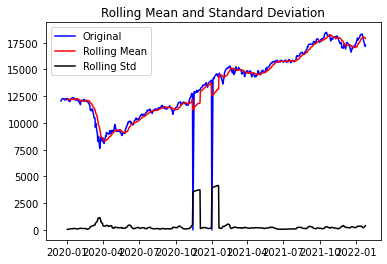

Results of dickey fuller test
Test Statistics                 -0.530986
p-value                          0.885827
No. of lags used                 7.000000
Number of observations used    519.000000
critical value (1%)             -3.443013
critical value (5%)             -2.867125
critical value (10%)            -2.569745
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)


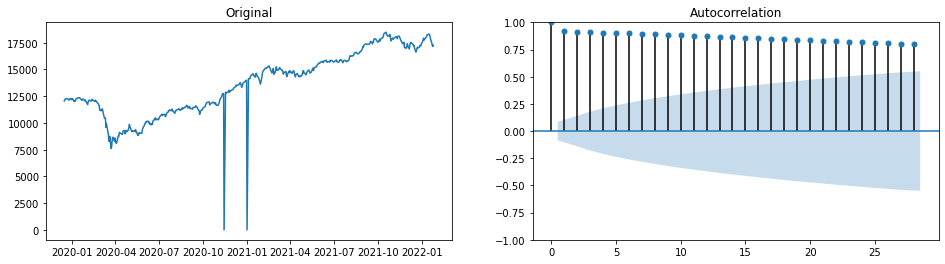

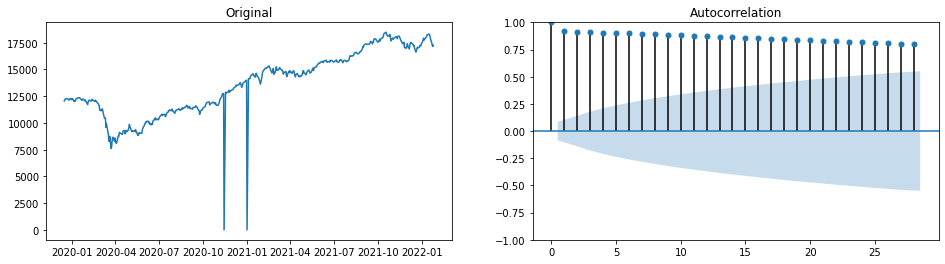

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
#my_pandas_series = pd.Series([x%3 for x in range(100)])
#decomposed = sm.tsa.seasonal_decompose(my_pandas_series.values, freq=3)
#result = seasonal_decompose(df_close, model='multiplicative', freq = 1)
#fig = plt.figure()
#fig = result.plot()
#fig.set_size_inches(16, 9)
#from statsmodels.graphics.teaplots import plot_acf
import statsmodels.graphics.tsaplots as sgt
fig, (ax1,ax2)=plt.subplots(1,2, figsize=(16,4))
ax1.plot(stock_data.Close)
ax1.set_title("Original")
sgt.plot_acf(stock_data.Close, ax=ax2)


In [ ]:
from pmdarima.arima.utils import ndiffs
ndiffs(stock_data.Close, test="adf")

1

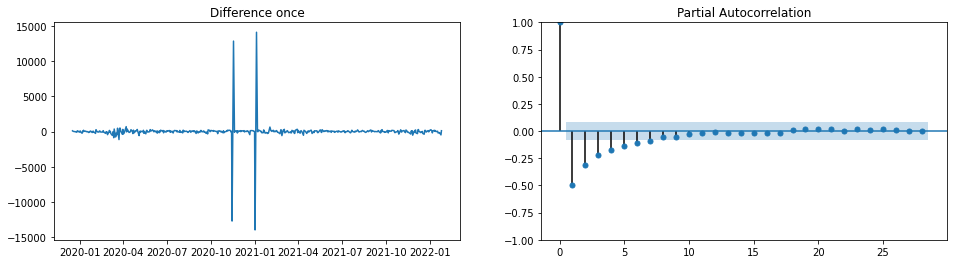

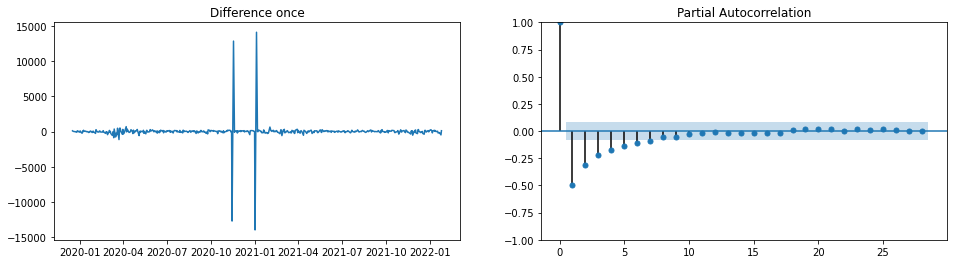

In [ ]:
#p (order of the Autoregressive Term)
#from statsmodels.graphics.teaplots import plot_pacf
diff = stock_data.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
sgt.plot_pacf(diff, ax=ax2)

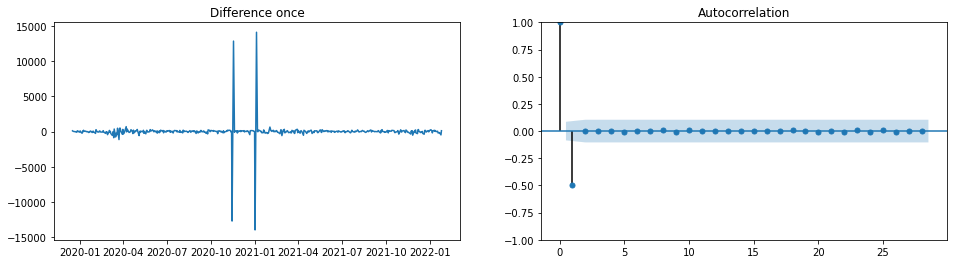

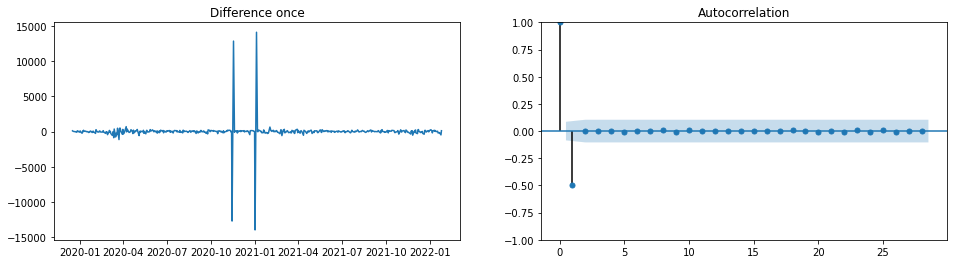

In [ ]:
#q
diff = stock_data.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
sgt.plot_acf(diff, ax=ax2)

**Fitting the model**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(stock_data.Close, order=(6, 1, 3))
result = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  525
Model:                 ARIMA(6, 1, 3)   Log Likelihood               -4330.987
Date:                Sun, 27 Mar 2022   AIC                           8681.974
Time:                        14:04:30   BIC                           8724.589
Sample:                             0   HQIC                          8698.662
                                - 525                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6308     19.540      0.032      0.974     -37.666      38.928
ar.L2          0.1210     16.541      0.007      0.994     -32.299      32.541
ar.L3         -0.0291      0.819     -0.036      0.9

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00038638],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 array([-13826.97308473, -11238.88075675,  -8650.78842878,  -6062.69610081,
         -3474.60377284,   -886.51144486,   1701.58088311,   4289.67321108,
          6877.76553905,   9465.85786703,  12053.950195  ]),
 <a list of 525 Lists of Patches objects>)

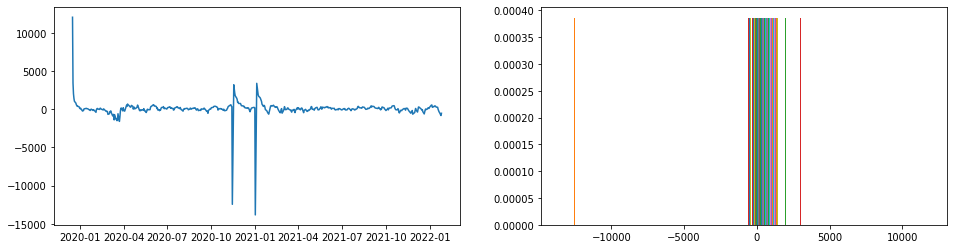

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)


In [ ]:
# Actual vs Fitted
!pip install statsmodels


In [ ]:
stock_data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-16,12131.349609,12134.650391,12046.299805,12053.950195,12053.950195,437700.0
2019-12-17,12082.450195,12182.750000,12070.349609,12165.000000,12165.000000,499600.0
2019-12-18,12197.000000,12237.700195,12163.450195,12221.650391,12221.650391,518900.0
2019-12-19,12223.400391,12268.349609,12191.150391,12259.700195,12259.700195,623100.0
2019-12-20,12266.450195,12293.900391,12252.750000,12271.799805,12271.799805,810700.0
...,...,...,...,...,...,...
2022-01-19,18129.199219,18129.199219,17884.900391,17938.400391,17938.400391,276700.0
2022-01-20,17921.000000,17943.699219,17648.449219,17757.000000,17757.000000,258100.0
2022-01-21,17613.699219,17707.599609,17485.849609,17617.150391,17617.150391,277600.0


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


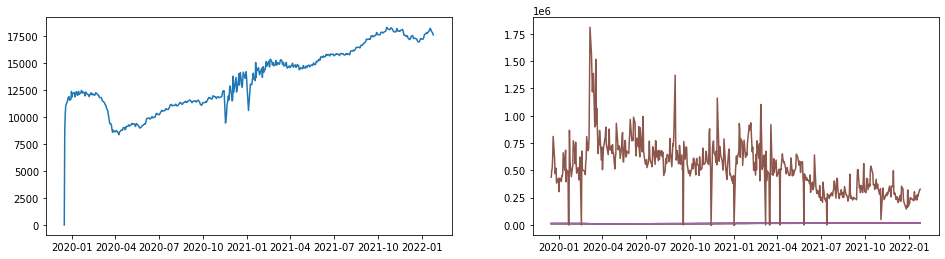

In [ ]:
import statsmodels.api as sm

#model = sm(stock_data.Close, order=(6, 1, 3))

model = sm.tsa.arima.ARIMA(stock_data.Close,order=(10, 1, 10))
result1 = model.fit()
pred = result1.predict(start='2019-12-16', end='2022-01-25')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
#fitted vs actual
ax1.plot(pred)
ax2.plot(stock_data)

#fig = result.plot_predict(
 #   start=1,
  #  end=10,
   # dynamic=False,
#)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Text(0.5, 1.0, 'Original V Fitted')

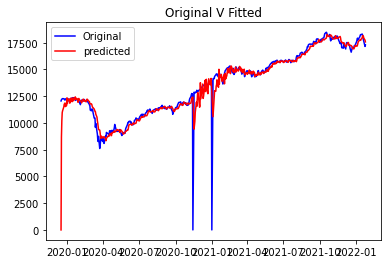

In [ ]:
import statsmodels.api as sm


model = sm.tsa.arima.ARIMA(stock_data.Close,order=(10, 1, 10))
result1 = model.fit()
pred = result1.predict(start='2019-12-16', end='2022-01-25')
plt.plot(stock_data['Close'], color='blue',label='Original')
plt.plot(pred, color='red',label='predicted')
plt.legend(loc='best')
plt.title('Original V Fitted')